# Confirmed cases and country trajectory charts for Poland
> Day by day statistics of new confirmed cases and comparison with other countries.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/chart-preview.png

In [1]:
#hide
%load_ext autoreload
%autoreload 2

In [2]:
#hide
import pandas as pd
import altair as alt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
%matplotlib inline
sns.set()

from scripts.data import get_covid_data, get_growth_rate_data

from scripts.plots import plot_confirmed_cases_barplot, plot_new_cases_per100, plot_new_cases_barplot, make_since_chart, plot_confirmed_cases_per100

In [3]:
#hide
url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
       'csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df = pd.read_csv(url)
# rename countries
df['Country/Region'] = df['Country/Region'].replace({'Korea, South': 'South Korea'})
df = df[~df['Country/Region'].isin(['Cruise Ship'])]   # Remove Ships
dt_cols = df.columns[~df.columns.isin(['Province/State', 'Country/Region', 'Lat', 'Long'])]

## New daily cases

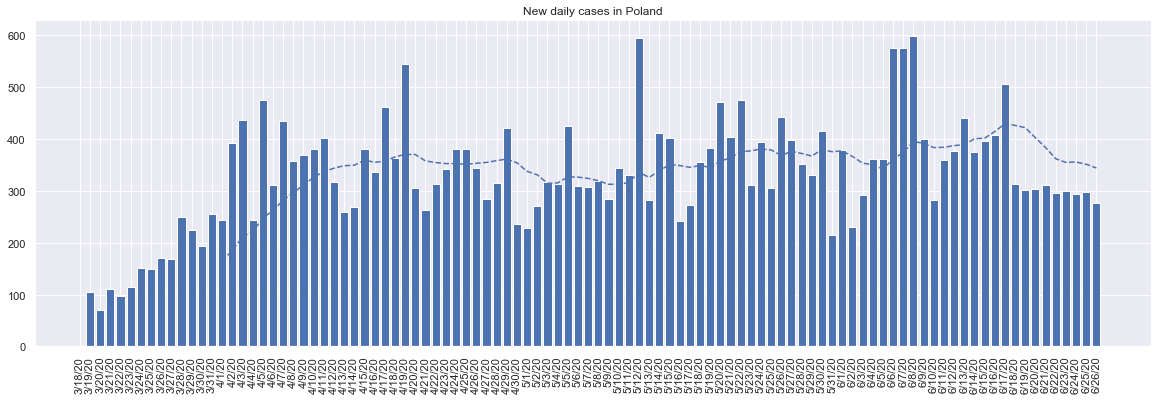

In [4]:
#hide_input
plot_new_cases_barplot(df, 'Poland', window=14, cutoff=60)

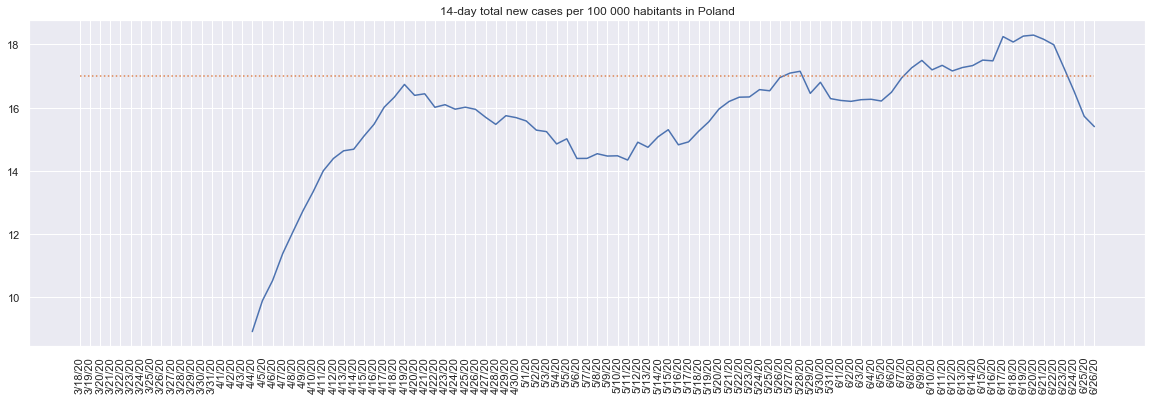

In [6]:
#hide_input
plot_new_cases_per100(df, 'Poland', total_population=37970000 ,cutoff=60)

## Number of total cases in Poland


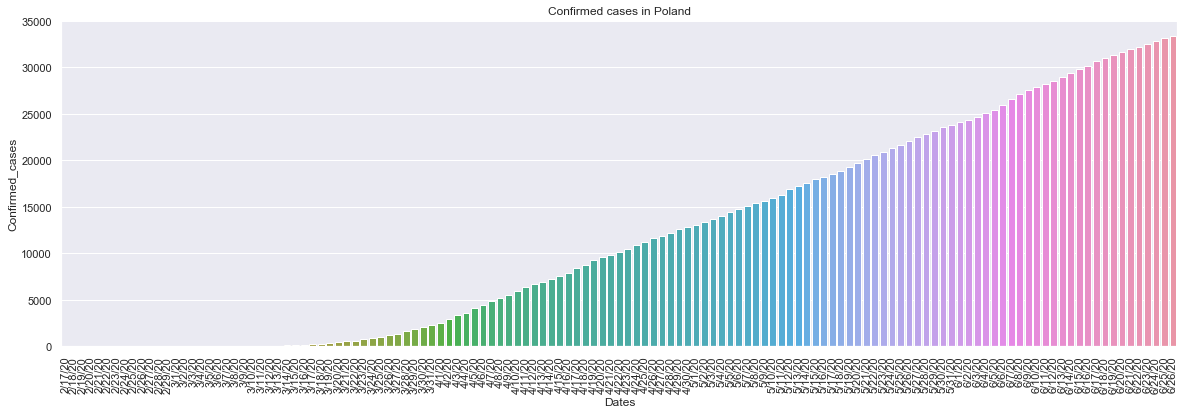

In [7]:
#hide_input
plot_confirmed_cases_barplot(df,'Poland', cutoff=30)

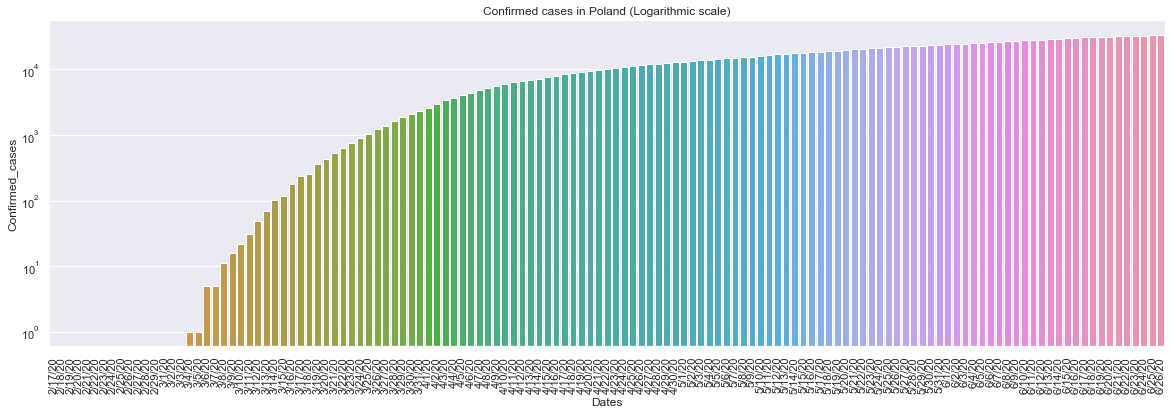

In [8]:
#hide_input
plot_confirmed_cases_barplot(df, 'Poland', cutoff=30, logarithmic_scale=True)

## Country trajectories for total cases

Compare how the growth rate is different from other countries and their trajectories. By days since 100th confirmed case.

> Tip: Click (Shift+ for multiple) on countries in the legend to filter the visualization. 

In [9]:
#hide
countries_to_show = ['Lithuania', 'Poland', 'Russia', 'United States' , 'Belgium', 'United Kingdom', 'China', 'Italy', 'Germany', 'Ukraine', 'Czechia', 'Estonia', 'US', 'France', 'Canada', 'Japan', 'South Korea', 'Latvia', 'Spain']
baseline_countries = ['Italy']
dff2 = get_growth_rate_data(df, countries_to_show)

In [10]:
#hide_input
chart3 = make_since_chart(dff2, ['Poland', 'Canada', 'South Korea'], baseline_countries)
chart3


alt.LayerChart(...)

In [11]:
#hide_input
chart2 = make_since_chart(dff2,['Poland', 'Germany', 'Czechia'], baseline_countries)
chart2

alt.LayerChart(...)

In [12]:

#hide_input
chart2 = make_since_chart(dff2, ['Ukraine', 'Poland'], baseline_countries)
chart2

alt.LayerChart(...)

In [13]:
#hide_input
chart2 = make_since_chart(dff2, ['Poland', 'Spain', 'US'], baseline_countries)
chart2

alt.LayerChart(...)

In [14]:

#hide_input
chart2 = make_since_chart(dff2, ['France', 'Greece', 'Poland'], baseline_countries)
chart2

alt.LayerChart(...)

## New daily cases in other countries

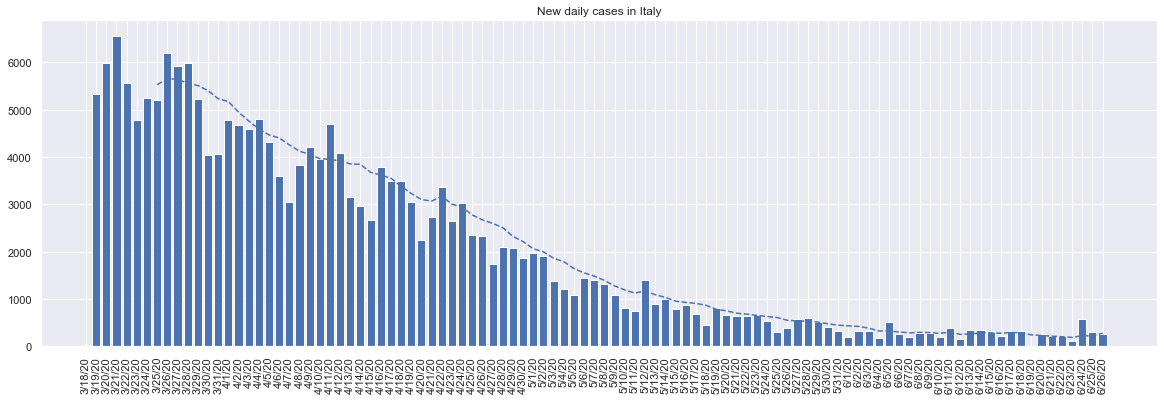

In [15]:
#hide_input
plot_new_cases_barplot(df,'Italy')

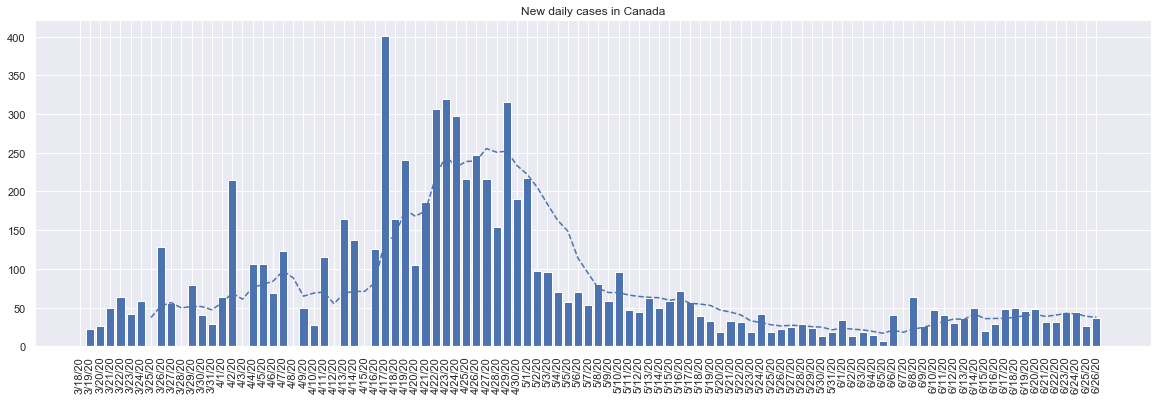

In [16]:
#hide
plot_new_cases_barplot(df,'Canada')

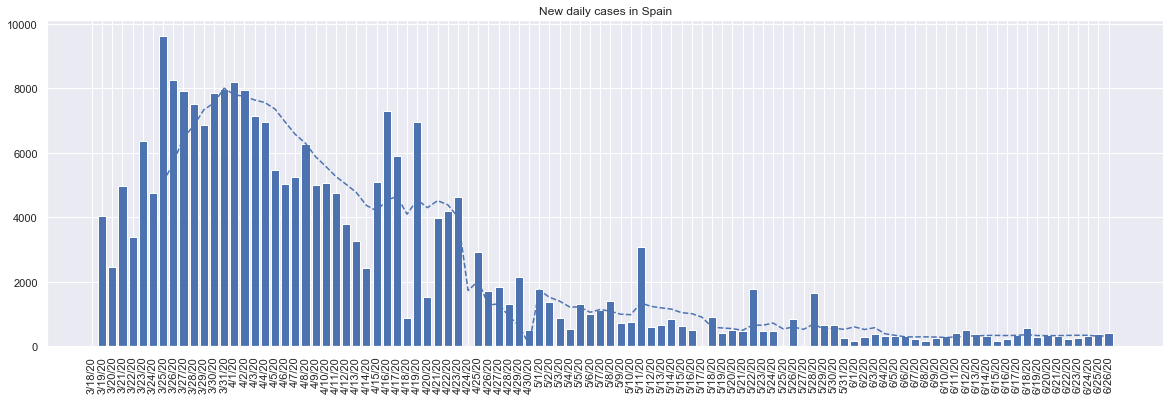

In [17]:
#hide_input
plot_new_cases_barplot(df,'Spain')

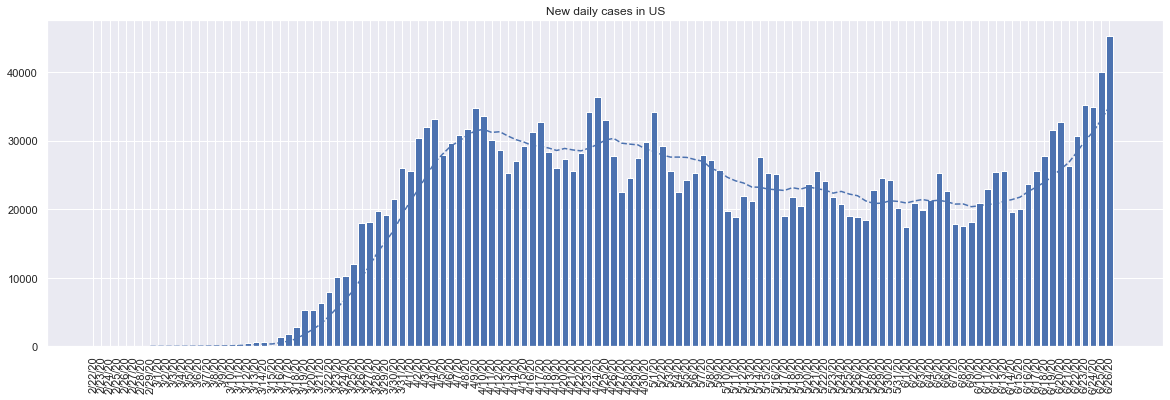

In [18]:
#hide_input
plot_new_cases_barplot(df, 'US', cutoff=35)

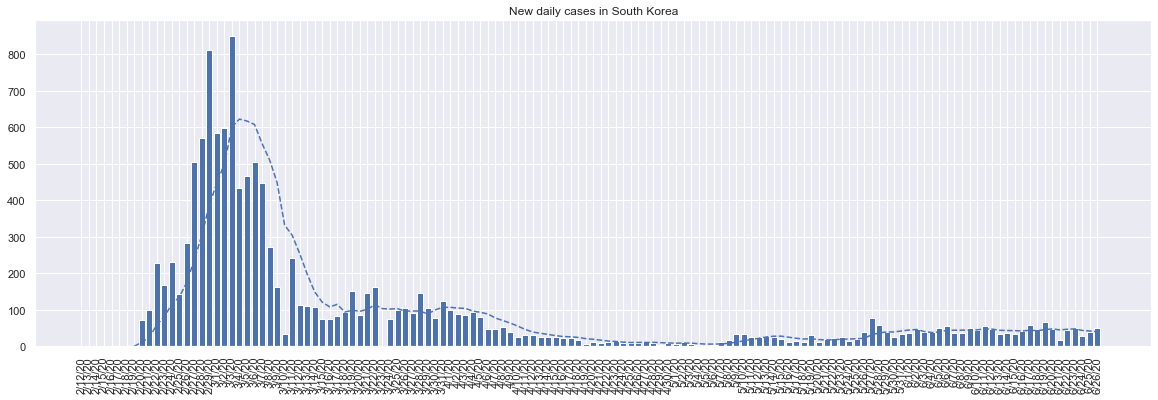

In [19]:
#hide_input
plot_new_cases_barplot(df, 'South Korea', cutoff=25)

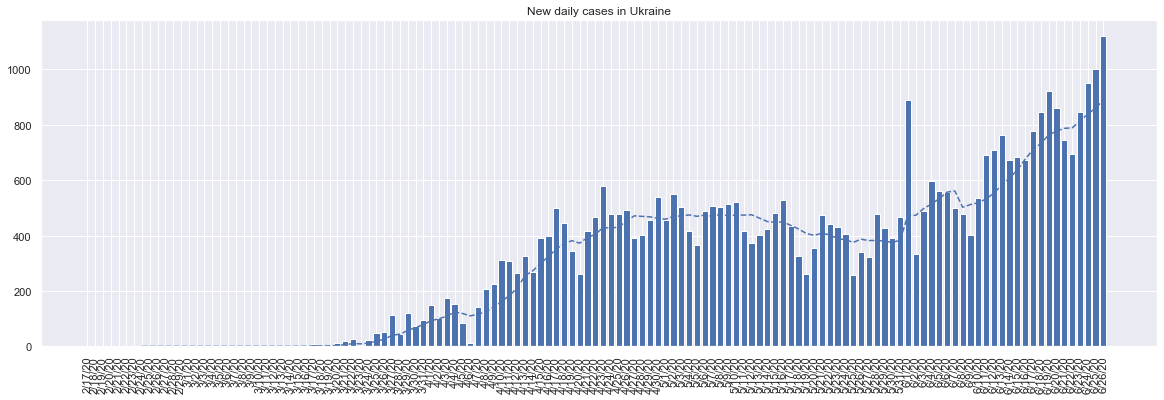

In [20]:
#hide_input
plot_new_cases_barplot(df,'Ukraine', cutoff=30)

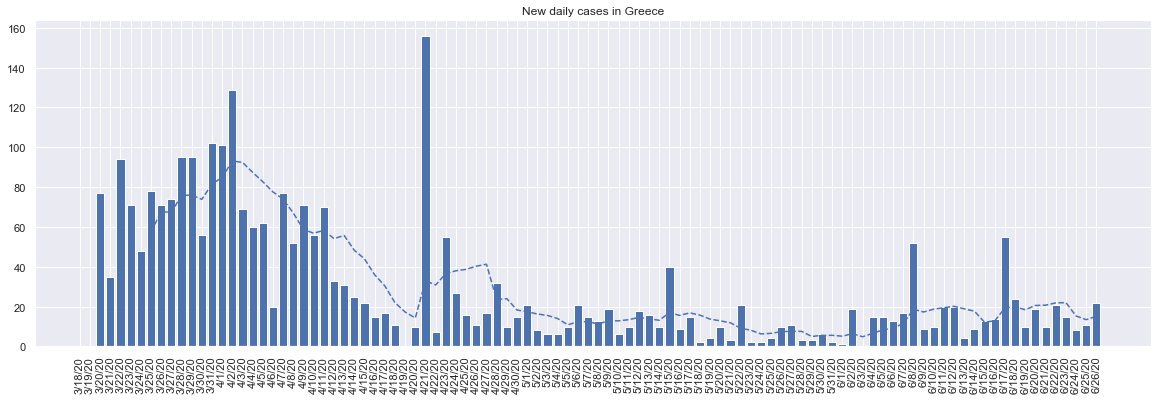

In [21]:
#hide_input
plot_new_cases_barplot(df,'Greece')

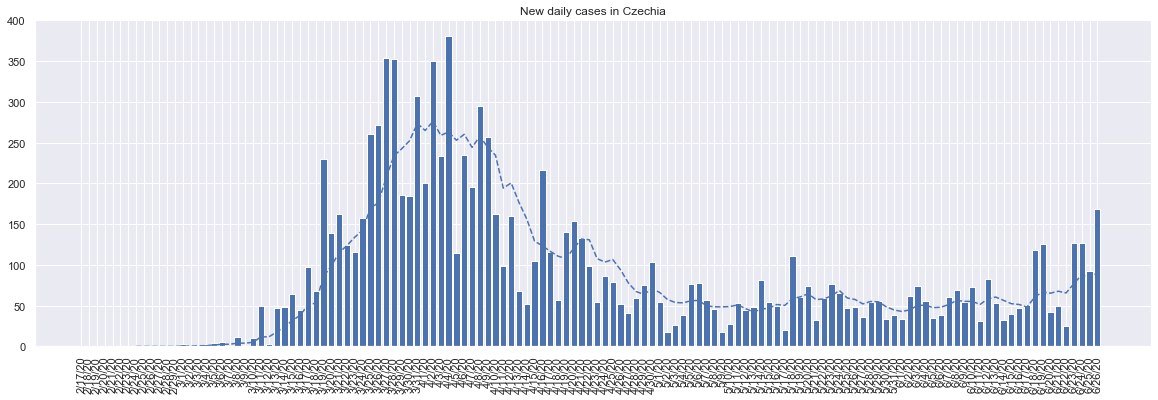

In [22]:
#hide_input
plot_new_cases_barplot(df,'Czechia', cutoff=30)

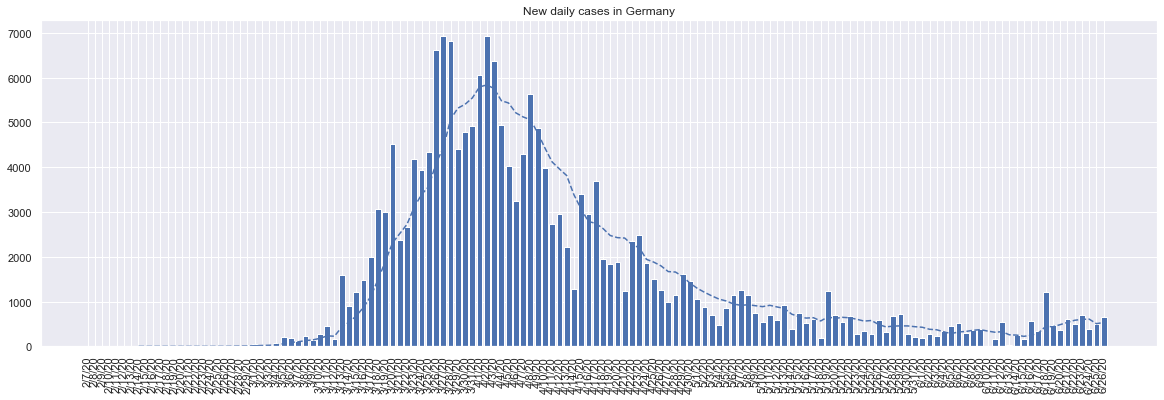

In [23]:
#hide_input
plot_new_cases_barplot(df, 'Germany', cutoff=20)

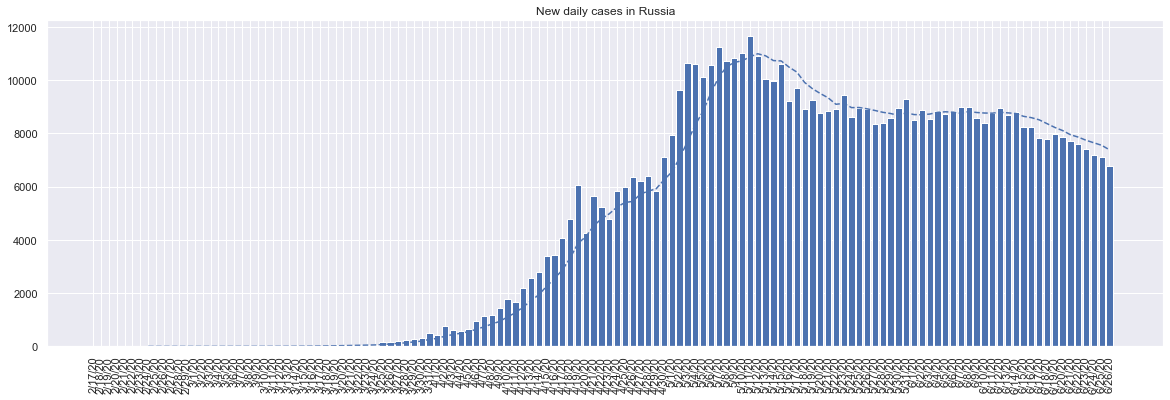

In [24]:
#hide_input
plot_new_cases_barplot(df, 'Russia', cutoff=30)

## Total cases per 100 000

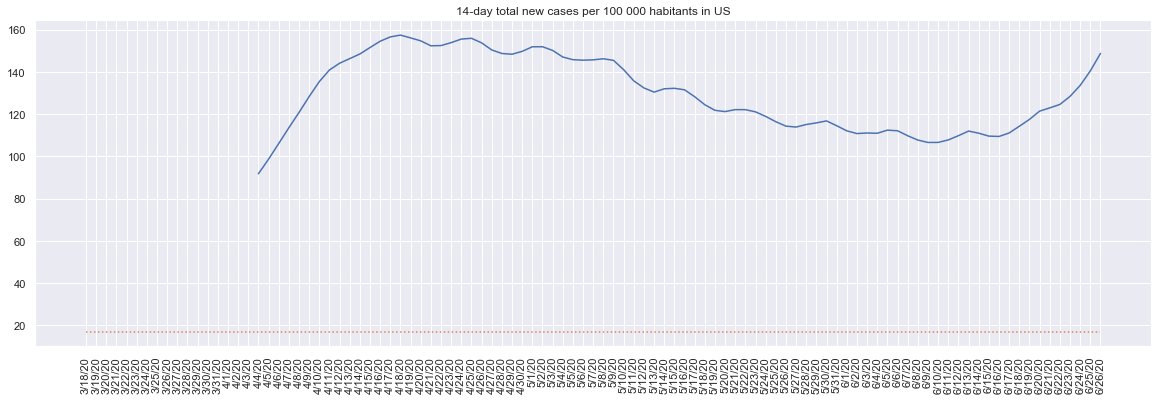

In [25]:
#hide_input
plot_new_cases_per100(df, 'US', total_population=328000000)

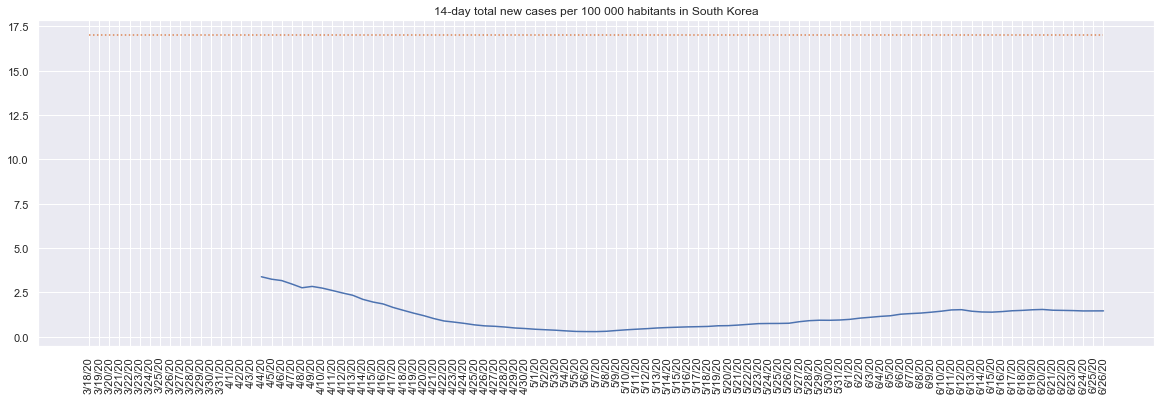

In [26]:
#hide_input
plot_new_cases_per100(df, 'South Korea', total_population=51640000 )

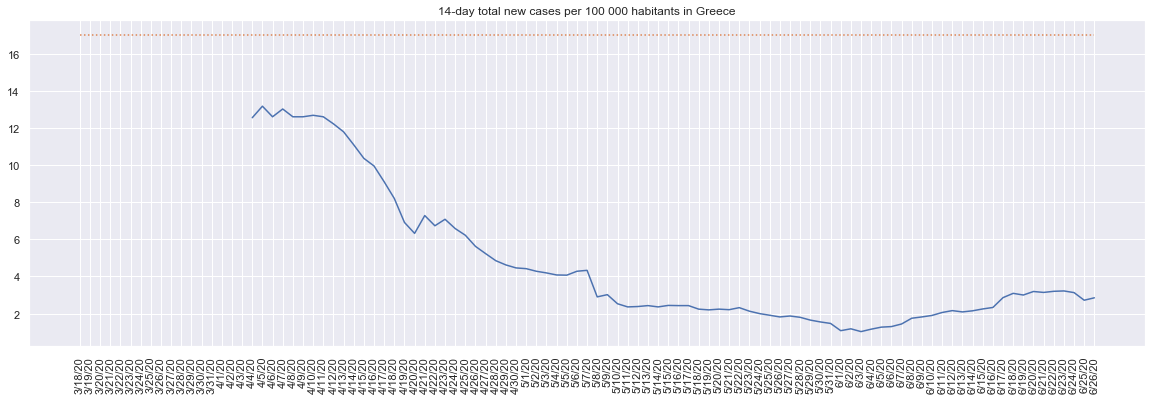

In [27]:
#hide_input
plot_new_cases_per100(df, 'Greece', total_population=10000000)

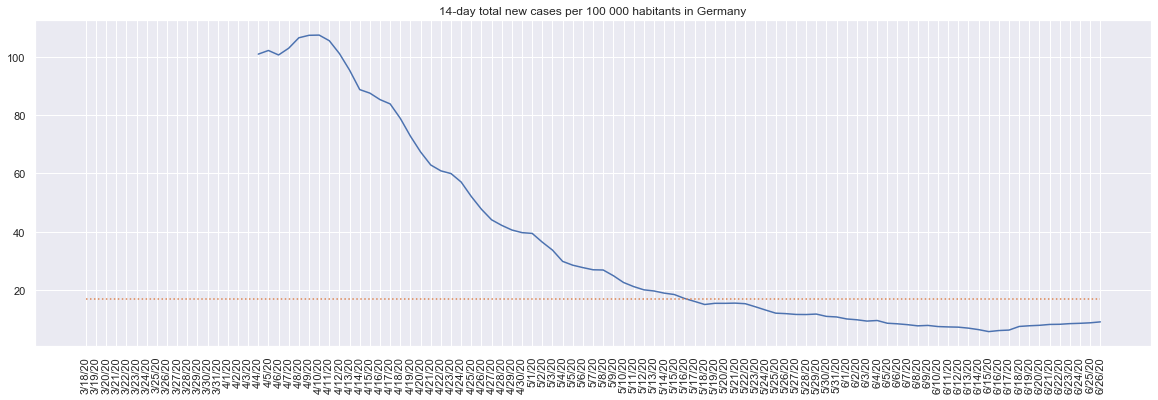

In [28]:
#hide_input
plot_new_cases_per100(df, 'Germany', total_population=83020000)

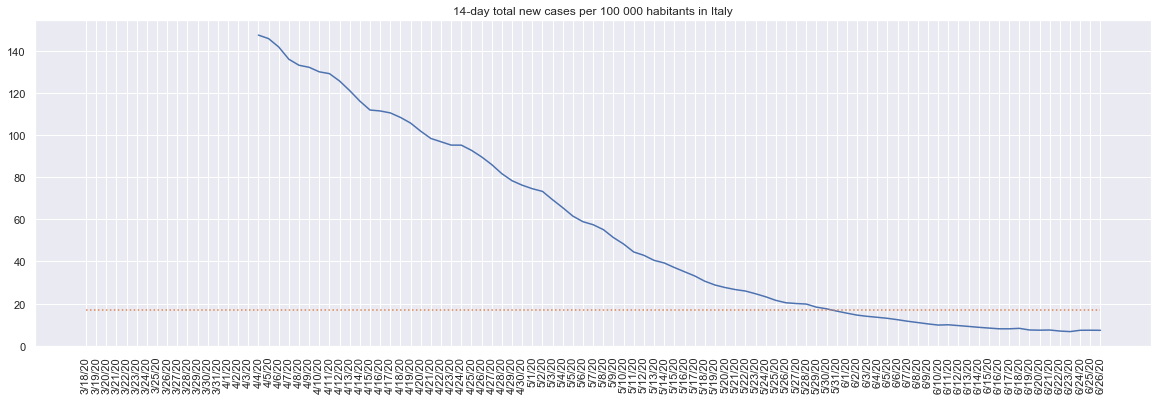

In [29]:
#hide_input
plot_new_cases_per100(df, 'Italy', total_population=60360000)

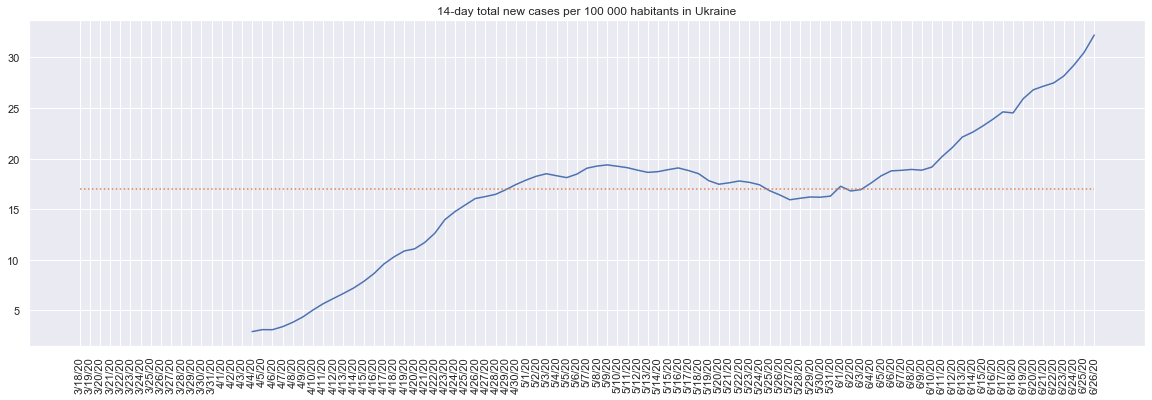

In [30]:
#hide_input
plot_new_cases_per100(df, 'Ukraine', total_population=41980000)

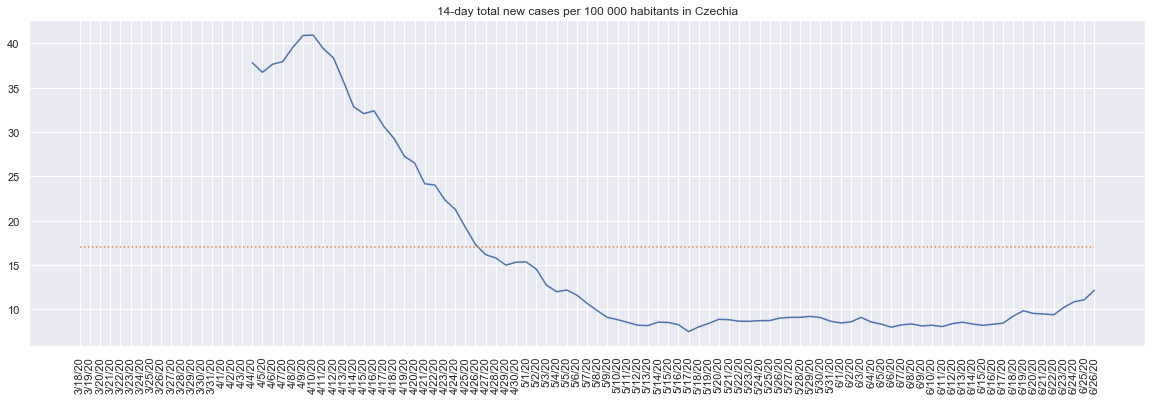

In [31]:
#hide_input
plot_new_cases_per100(df, 'Czechia', total_population=10690000)